In [12]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score,  f1_score
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
file_url = "https://github.com/Yihe-Harry/DSA3101-Group-Project/tree/Subgroup-B/GrpB_models/B5_Marcus/default of credit card clients.xls"

df = pd.read_excel(file_url, header=1)
print(df.head())

Mounted at /content/drive
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month 

In [3]:
# replace -2 with 0 in repayment status columns
df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']] = df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].replace(-2, 0)

# apply one-hot encoding to 'PAY_0' ...
df = pd.get_dummies(df, columns=['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'], drop_first=True)



df['Sudden_Large_Payment'] = ((df['PAY_AMT1'] > df['BILL_AMT1'] * 0.9) | (df['PAY_AMT2'] > df['BILL_AMT2'] * 0.9)).astype(int)
df['Decreasing_Usage'] = ((df['BILL_AMT2'] > df['BILL_AMT1']) &
                          (df['BILL_AMT3'] > df['BILL_AMT2'])).astype(int) #decreasing card usage for last 3 mths


df['Churn'] = ((df[['BILL_AMT1', 'BILL_AMT2']].sum(axis=1) == 0) |  #last 2 mths 0 payments
               (df['Decreasing_Usage'] == 1) |
               (df['Sudden_Large_Payment'] == 1)).astype(int)  # suddenly pay off balance and stop

print(df.head())

#check churn distribution
print(df['Churn'].value_counts(normalize=True))

   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  BILL_AMT1  BILL_AMT2  \
0   1      20000    2          2         1   24       3913       3102   
1   2     120000    2          2         2   26       2682       1725   
2   3      90000    2          2         2   34      29239      14027   
3   4      50000    2          2         1   37      46990      48233   
4   5      50000    1          2         1   57       8617       5670   

   BILL_AMT3  BILL_AMT4  ...  PAY_6_2  PAY_6_3  PAY_6_4  PAY_6_5  PAY_6_6  \
0        689          0  ...    False    False    False    False    False   
1       2682       3272  ...     True    False    False    False    False   
2      13559      14331  ...    False    False    False    False    False   
3      49291      28314  ...    False    False    False    False    False   
4      35835      20940  ...    False    False    False    False    False   

   PAY_6_7  PAY_6_8  Sudden_Large_Payment  Decreasing_Usage  Churn  
0    False    False          

In [4]:
print(df.columns)

features = [
    "LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE",
     'PAY_3_0', 'PAY_3_1', 'PAY_3_2',
       'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6', 'PAY_3_7', 'PAY_3_8',
       'PAY_4_0', 'PAY_4_1', 'PAY_4_2', 'PAY_4_3', 'PAY_4_4', 'PAY_4_5',
       'PAY_4_6', 'PAY_4_7', 'PAY_4_8', 'PAY_5_0', 'PAY_5_2', 'PAY_5_3',
       'PAY_5_4', 'PAY_5_5', 'PAY_5_6', 'PAY_5_7', 'PAY_5_8', 'PAY_6_0',
       'PAY_6_2', 'PAY_6_3', 'PAY_6_4', 'PAY_6_5', 'PAY_6_6', 'PAY_6_7',
       'PAY_6_8',
    "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
    "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6",
    ] #remove id, default, payamt1, payamt2, pay0, pay2, bill1, bill2, sudden large payment, low credit
target = "Churn"

x = df[features]
y = df[target]
print(x.head())
print(y.head())

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=3101)

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'PAY_0_0', 'PAY_0_1', 'PAY_0_2',
       'PAY_0_3', 'PAY_0_4', 'PAY_0_5', 'PAY_0_6', 'PAY_0_7', 'PAY_0_8',
       'PAY_2_0', 'PAY_2_1', 'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5',
       'PAY_2_6', 'PAY_2_7', 'PAY_2_8', 'PAY_3_0', 'PAY_3_1', 'PAY_3_2',
       'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6', 'PAY_3_7', 'PAY_3_8',
       'PAY_4_0', 'PAY_4_1', 'PAY_4_2', 'PAY_4_3', 'PAY_4_4', 'PAY_4_5',
       'PAY_4_6', 'PAY_4_7', 'PAY_4_8', 'PAY_5_0', 'PAY_5_2', 'PAY_5_3',
       'PAY_5_4', 'PAY_5_5', 'PAY_5_6', 'PAY_5_7', 'PAY_5_8', 'PAY_6_0',
       'PAY_6_2', 'PAY_6_3', 'PAY_6_4', 'PAY_6_5', 'PAY_6_6', 'PAY_6_7',
       'PAY_6_8', 'Sudden_Large_Payment', 'Decreasing_Usage', 'Churn'],
      dtype='object')
   LIMIT_BAL  SEX  EDUC

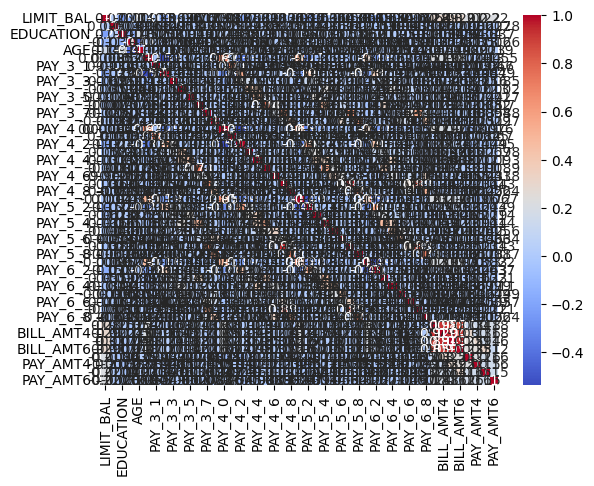

In [ ]:
correlation_matrix = df[features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Log regression

In [9]:
param_grid = {
    'C': [ 0.01, 0.1, 1, 10, 100],  # inverse of regularization strength
    'penalty': ['l1', 'l2'],  # regularization types
    'solver': ['liblinear'],
    'max_iter': [500, 1000, 2000]  #iterations for convergence
}

log_reg = LogisticRegression(random_state=3101)


grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=10, scoring='recall', verbose=1, n_jobs=-1)


grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_params)
print(f"Best cross-validation accuracy: {best_score:.4f}")


best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)


accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)



print(accuracy)
print(recall)
print(f1)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'C': 0.01, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.6669
0.6326666666666667
0.68837058632977
0.6585063526495197


# Random forest

In [ ]:
rf = RandomForestClassifier(class_weight='balanced', random_state=3101)

param_grid = {
    'n_estimators': [ 50, 100],  #number of trees
    'max_depth': [None, 1, 2],  #tree depth
    'min_samples_split': [2, 5],  #min samples to split a node
    'min_samples_leaf': [1, 2],  #min samples per leaf
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(rf, param_grid, cv=10, scoring='recall', n_jobs=-1)
grid_search.fit(x_train, y_train)

best_rf = grid_search.best_estimator_

cv_scores = cross_val_score(best_rf, x_train, y_train, cv=10, scoring='recall')
#print(cv_scores.mean())

y_pred = best_rf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

from sklearn.metrics import precision_score, f1_score
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")


Accuracy: 0.7061666666666667
Recall: 0.7003563330093943
Precision: 0.7206666666666667
F1 Score: 0.7103663545260391


this model we train it with a more balanced output with recall and f1 score roughly similar. this is due to the labels are being generated based on assumptions and may not be as accurate as the other dataset. hence this model will give a more balanced output than the other model

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[2075  838]
 [ 925 2162]]


# Important features

In [ ]:
feature_importance = best_rf.feature_importances_
features = x_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

      Feature  Importance
39  BILL_AMT3    0.123674
40  BILL_AMT4    0.096080
41  BILL_AMT5    0.091167
42  BILL_AMT6    0.088493
0   LIMIT_BAL    0.082086
4         AGE    0.074911
43   PAY_AMT3    0.073980
44   PAY_AMT4    0.064483
45   PAY_AMT5    0.063935
46   PAY_AMT6    0.063693
7     PAY_3_2    0.030271
5     PAY_3_0    0.029187
2   EDUCATION    0.024411
14    PAY_4_0    0.016069
3    MARRIAGE    0.015047
1         SEX    0.011977
23    PAY_5_0    0.009928
31    PAY_6_0    0.009389
16    PAY_4_2    0.007062
24    PAY_5_2    0.004932
32    PAY_6_2    0.004404
8     PAY_3_3    0.003975
33    PAY_6_3    0.001282
17    PAY_4_3    0.001253
21    PAY_4_7    0.001176
9     PAY_3_4    0.001090
25    PAY_5_3    0.001078
29    PAY_5_7    0.000744
26    PAY_5_4    0.000678
18    PAY_4_4    0.000581
37    PAY_6_7    0.000580
34    PAY_6_4    0.000535
12    PAY_3_7    0.000454
10    PAY_3_5    0.000383
19    PAY_4_5    0.000297
11    PAY_3_6    0.000269
27    PAY_5_5    0.000111
35    PAY_6_

# Key insights

<ipython-input-13-75886b75582f>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_balance = df.groupby('Balance_Range')['Churn'].mean() * 100
<ipython-input-13-75886b75582f>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_by_balance.index, y=churn_by_balance.values, palette='coolwarm')


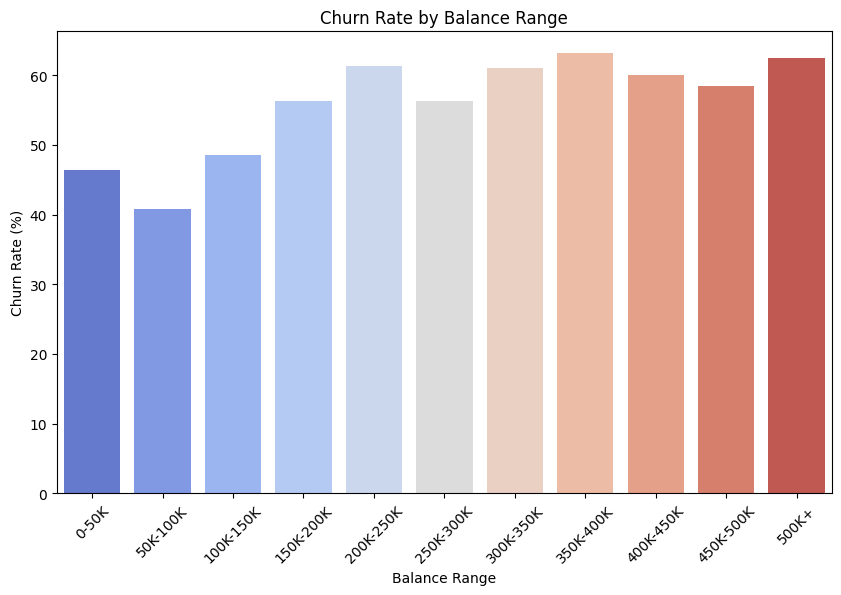

T-statistic: -24.67289224683638, P-value: 4.4465127244701054e-133
There is a significant difference in churn rates between low and high balance customers.


In [13]:

balance_bins = [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000]
balance_labels = ['0-50K', '50K-100K', '100K-150K', '150K-200K', '200K-250K', '250K-300K', '300K-350K', '350K-400K', '400K-450K', '450K-500K', '500K+']
df['Balance_Range'] = pd.cut(df['LIMIT_BAL'], bins=balance_bins, labels=balance_labels, right=False)

# cal churn rate for each bin
churn_by_balance = df.groupby('Balance_Range')['Churn'].mean() * 100

#plot
plt.figure(figsize=(10, 6))
sns.barplot(x=churn_by_balance.index, y=churn_by_balance.values, palette='coolwarm')
plt.title('Churn Rate by Balance Range')
plt.xlabel('Balance Range')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45)
plt.show()

low_balance = df[df['LIMIT_BAL'] <= 100000]  # low balance: <=100K
high_balance = df[df['LIMIT_BAL'] > 100000]  # high balance: >100K

t_stat, p_val = ttest_ind(low_balance['Churn'], high_balance['Churn'])
print(f"T-statistic: {t_stat}, P-value: {p_val}")

if p_val < 0.05:
    print("There is a significant difference in churn rates between low and high balance customers.")
else:
    print("There is no significant difference in churn rates between low and high balance customers.")


# Production ready

In [ ]:
import joblib
joblib.dump(best_rf, 'churn_prediction_model2.pkl')


best_rf = joblib.load('churn_prediction_model2.pkl')